# Build agents

Agents a r built according the reAct pattern.

see https://til.simonwillison.net/llms/python-react-pattern

This notebook shows the principles to implement an Agent System with Langchain.


In [4]:
import openai
import re
import httpx
import os
from dotenv import load_dotenv
from openai import OpenAI

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [5]:
# create the client and check the completion
client = openai.Client(api_key=os.getenv("OPENAI_API_KEY"))
chat_completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": "Hello world"}]
)

chat_completion.choices[0].message.content

'Hello! How can I assist you today?'

In [9]:
# create the Agent parameterized by system messages
class Agent:
    # system messages
    def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})
    # call messeges tales the user message appends it to the messages list and calls the execute method
    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        # append the result to the messages list
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = client.chat.completions.create(
                        model="gpt-4o", 
                        temperature=0,
                        messages=self.messages)
        return completion.choices[0].message.content
    

In [11]:
# construct the syetme message
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

In [12]:
def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

In [13]:
abot = Agent(prompt)

In [14]:
result = abot("How much does a toy poodle weigh?")
print(result)

Thought: I should look up the average weight of a Toy Poodle using the average_dog_weight action.
Action: average_dog_weight: Toy Poodle
PAUSE


In [16]:
result = average_dog_weight("Toy Poodle")
result

'a toy poodles average weight is 7 lbs'

In [18]:
next_prompt = "Observation: {}".format(result)
abot(next_prompt)

'Answer: A Toy Poodle weighs an average of 7 lbs.'

In [19]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
abot(question)

'Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then add them together to find their combined weight.\nAction: average_dog_weight: Border Collie\nPAUSE'

In [24]:
next_prompt = "Observation: {}".format(average_dog_weight("Border Collie"))
print(next_prompt)

Observation: a Border Collies average weight is 37 lbs


In [21]:
abot(next_prompt)

'Action: average_dog_weight: Scottish Terrier\nPAUSE'

In [22]:
next_prompt = "Observation: {}".format(average_dog_weight("Scottish Terrier"))
print(next_prompt)

Observation: Scottish Terriers average 20 lbs


In [23]:
abot(next_prompt)


'Thought: Now that I have the average weights of both the Border Collie and the Scottish Terrier, I can calculate their combined weight by adding these two values together.\nAction: calculate: 37 + 20\nPAUSE'

In [25]:
next_prompt = "Observation: {}".format(eval("37 + 20"))
print(next_prompt)

Observation: 57


In [26]:
abot(next_prompt)

'Answer: The combined average weight of a Border Collie and a Scottish Terrier is 57 lbs.'

In [27]:
abot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weights 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs'},
 {'role': 'user', 'content': 'How much does a 

In [29]:
action_re = re.compile('^Action: (\w+): (.*)$')

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
/var/folders/2q/0d84nxdx5vs59dmrwvkdmzch0000gn/T/ipykernel_54881/1336279184.py:1: SyntaxWarning: invalid escape sequence '\w'
  action_re = re.compile('^Action: (\w+): (.*)$')


In [31]:
def query(question, max_turns=5):
    i = 0
    bot = Agent(prompt)
    next_prompt = question
    while i < max_turns:
        i += 1
        result = bot(next_prompt)
        print(result)
        actions = [
            action_re.match(a) 
            for a in result.split('\n') 
            if action_re.match(a)
        ]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return

In [32]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)

Thought: I need to find the average weight of a Border Collie and a Scottish Terrier, then add them together to get the combined weight.
Action: average_dog_weight: Border Collie
PAUSE
 -- running average_dog_weight Border Collie
Observation: a Border Collies average weight is 37 lbs
Action: average_dog_weight: Scottish Terrier
PAUSE
 -- running average_dog_weight Scottish Terrier
Observation: Scottish Terriers average 20 lbs
Thought: Now that I have the average weights of both dogs, I can calculate their combined weight by adding the two values together.
Action: calculate: 37 + 20
PAUSE
 -- running calculate 37 + 20
Observation: 57
Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.


## Langgraph

As an extension of LangChain, with LangGraph multi-agent flows are described and represented as graphs.

- allows for controlled flows
- built in persistences allows human-in-the-loop workflows



In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [6]:
_set_env("TAVILY_API_KEY")

## create a Tool for the agent
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [7]:
class Agent:
    # agent needs model, tool and system statement
    def __init__(self, model, tools, system=""):
        self.system = system
        # during initialization, the agent creates a graph
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [16]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

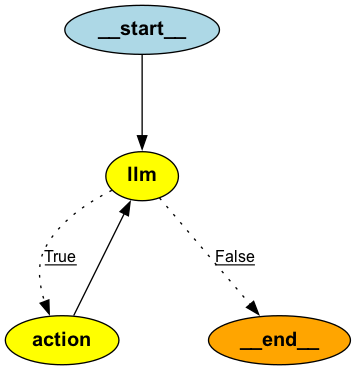

In [18]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [10]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_Ro5YGavwIu7xNinL10fC1aP3', 'type': 'tool_call'}
Back to the model!


In [11]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ro5YGavwIu7xNinL10fC1aP3', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6d66b2a7-520d-4590-aee5-1209f2a28627-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_Ro5YGavwIu7xNinL10fC1aP3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{

In [12]:
result['messages'][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 53.1°F (11.7°C). The wind speed is 5.8 mph (9.4 kph) from the WSW direction. The humidity is at 93%, and the visibility is 9.0 miles.'

In [13]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_XNHaDufZE6cGpdn54ZnqEch3', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_e3zBvoMX9qZkisdealdfBixM', 'type': 'tool_call'}
Back to the model!


In [14]:
result['messages'][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 53.1°F. The wind speed is 5.8 mph, and the humidity is at 93%.\n\nIn Los Angeles, it is sunny with a temperature of 72.6°F. The wind speed is 2.2 mph, and the humidity is at 50%.'

In [15]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_oRlcyvr0gbazjRtKiR0qjbXF', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_dK1RL1dLF6WltDrNwdfJKVjK', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2024'}, 'id': 'call_pzMfEw5K4a03OZgAbzm1SRnZ', 'type': 'tool_call'}
Back to the model!


In [ ]:
print(result['messages'][-1].content)

## Search Tool

```mermaid
flowchart LR;
    P(["Prompt"])-->A1["Agent"]-->A2["Agent"];
    S("Search Tool")
    A1--Search Tool-->S;
    S--RAG Content-->A2;
    style S fill:#20AD7A
   
```

inside search Tool

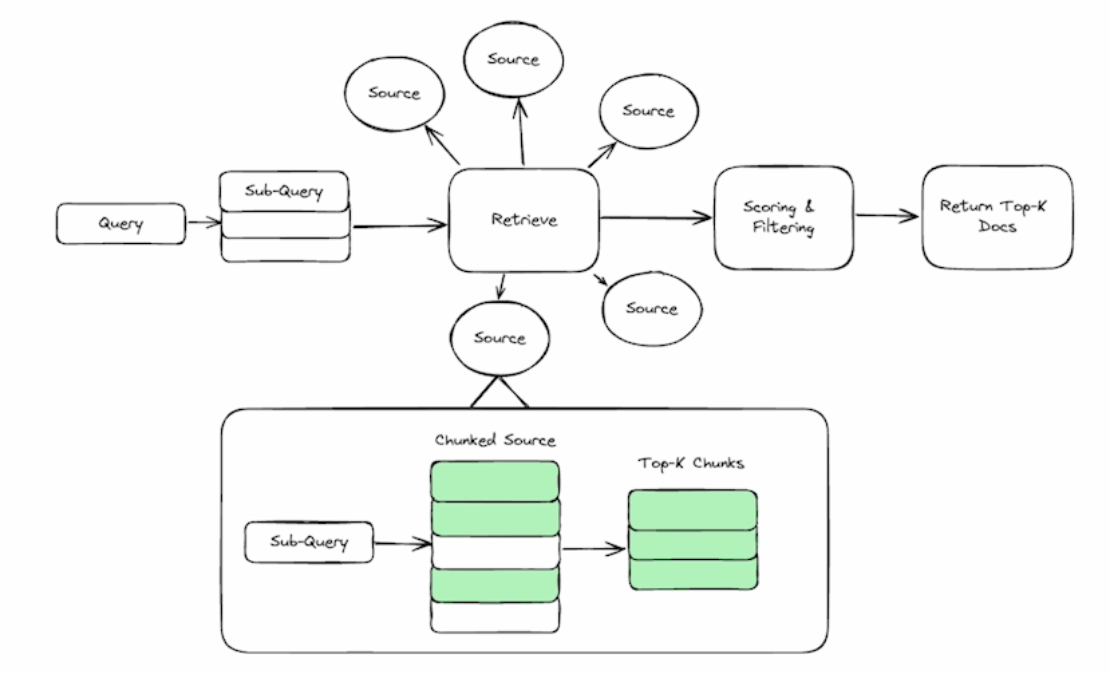

In [19]:
from dotenv import load_dotenv
import os
from tavily import TavilyClient

In [20]:
# load environment variables from .env file
_ = load_dotenv()

# connect
client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

In [21]:
# run search
result = client.search("What is in Nvidia's new Blackwell GPU?",
                       include_answer=True)

# print the answer
result["answer"]

'The Nvidia Blackwell GPU architecture features two new GPUs, the B100 and B200. These GPUs offer a dual-die design with four HBM3e memory stacks per die, providing 24GB per stack and a bandwidth of 1 TB/s on a 1024-bit interface. The Blackwell architecture boasts 30X more performance and 25X more energy efficiency compared to its predecessor. Additionally, the Blackwell GPU includes features such as a Decompression Engine, access to massive memory in the NVIDIA Grace CPU, a second-generation Transformer Engine, NVLink, and NVLink Switch technology for enhanced communication among GPUs within a server cluster.'

In [22]:
# choose location (try to change to your own city!)

city = "San Francisco"

query = f"""
    what is the current weather in {city}?
    Should I travel there today?
    "weather.com"
"""

In [23]:
import requests
from bs4 import BeautifulSoup
from duckduckgo_search import DDGS
import re

ddg = DDGS()

def search(query, max_results=6):
    try:
        results = ddg.text(query, max_results=max_results)
        return [i["href"] for i in results]
    except Exception as e:
        print(f"returning previous results due to exception reaching ddg.")
        results = [ # cover case where DDG rate limits due to high deeplearning.ai volume
            "https://weather.com/weather/today/l/USCA0987:1:US",
            "https://weather.com/weather/hourbyhour/l/54f9d8baac32496f6b5497b4bf7a277c3e2e6cc5625de69680e6169e7e38e9a8",
        ]
        return results  


for i in search(query):
    print(i)

https://weather.com/weather/today/l/San+Francisco+CA?canonicalCityId=45cf83277ba620e7dc8a0fe8b6eda89925a3e6d2e1bdfef3f74a1590017bd70d
https://weather.com/weather/tenday/l/San+Francisco+CA+USCA0987:1:US


In [24]:
def scrape_weather_info(url):
    """Scrape content from the given URL"""
    if not url:
        return "Weather information could not be found."
    
    # fetch data
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return "Failed to retrieve the webpage."

    # parse result
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup


In [25]:
# use DuckDuckGo to find websites and take the first result
url = search(query)[0]

# scrape first wesbsite
soup = scrape_weather_info(url)

print(f"Website: {url}\n\n")
print(str(soup.body)[:50000]) # limit long outputs

Website: https://weather.com/weather/today/l/San+Francisco+CA+USCA0987:1:US


<body><div class="appWrapper DaybreakLargeScreen LargeScreen lightTheme twcTheme DaybreakLargeScreen--appWrapper--ZkDop gradients--cloudyFoggyDay--lBhxD gradients--cloudyFoggyDay-top---jGZr" id="appWrapper"><div class="region-meta"><div class="removeIfEmpty" id="WxuHtmlHead-meta-"></div><div class="removeIfEmpty" id="WxuNewsroom-meta-bc9f40d5-d941-4fd8-bae2-2d8d63a38bb3"></div></div><div class="region-topAds regionTopAds DaybreakLargeScreen--regionTopAds--sDajQ"><div class="removeIfEmpty" id="WxuAd-topAds-53dce052-5465-4609-a555-c3a20ab64ab0"><div class="adWrapper BaseAd--adWrapper--ANZ1O BaseAd--card--cqv7t BaseAd--hide--hCG8L"><div class="adLabel BaseAd--adLabel--JGSp6">Advertisement</div><div class="ad_module BaseAd--ad_module--ajh9S subs-undefined BaseAd--placeholder--ofteC" id="WX_Hidden"></div></div></div><div class="removeIfEmpty" id="WxuAd-topAds-fe926b10-58bc-448a-ab09-47e692334250"><div class="adWra

In [26]:
# extract text
weather_data = []
for tag in soup.find_all(['h1', 'h2', 'h3', 'p']):
    text = tag.get_text(" ", strip=True)
    weather_data.append(text)

# combine all elements into a single string
weather_data = "\n".join(weather_data)

# remove all spaces from the combined text
weather_data = re.sub(r'\s+', ' ', weather_data)
    
print(f"Website: {url}\n\n")
print(weather_data)

Website: https://weather.com/weather/today/l/San+Francisco+CA+USCA0987:1:US


recents Weather Forecasts Radar & Maps News & Media Products Health & Wellness Privacy Lifestyle Specialty Forecasts San Francisco, CA Today's Forecast for San Francisco, CA Morning Afternoon Evening Overnight Weather Today in San Francisco, CA 7:14 am 6:37 pm Don't Miss Hourly Forecast Now 4 pm 5 pm 6 pm 7 pm Outside That's Not What Was Expected Daily Forecast Today Sat 12 Sun 13 Mon 14 Tue 15 Radar We Love Our Critters Seasonal Skin Solutions Home, Garage & Garden Teen Rescued Health News For You Happening Near San Francisco, CA Popular Nextdoor posts Rain Or Shine, It's Playtime Stay Safe Flu's Deadly Toll Weather in your inbox Your local forecast, plus daily trivia, stunning photos and our meteorologists’ top picks. All in one place, every weekday morning. By signing up, you're opting in to receive the Morning Brief email newsletter. To manage your data, visit Data Rights . Terms of Use | Privacy Policy A

In [27]:
# run search
result = client.search(query, max_results=1)

# print first result
data = result["results"][0]["content"]

print(data)

{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1728684189, 'localtime': '2024-10-11 15:03'}, 'current': {'last_updated_epoch': 1728684000, 'last_updated': '2024-10-11 15:00', 'temp_c': 13.0, 'temp_f': 55.4, 'is_day': 1, 'condition': {'text': 'Partly Cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 8.7, 'wind_kph': 14.0, 'wind_degree': 244, 'wind_dir': 'WSW', 'pressure_mb': 1018.0, 'pressure_in': 30.07, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 90, 'cloud': 59, 'feelslike_c': 12.2, 'feelslike_f': 53.9, 'windchill_c': 12.2, 'windchill_f': 53.9, 'heatindex_c': 13.0, 'heatindex_f': 55.4, 'dewpoint_c': 11.5, 'dewpoint_f': 52.7, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 3.6, 'gust_mph': 12.3, 'gust_kph': 19.9}}


In [28]:
import json
from pygments import highlight, lexers, formatters

# parse JSON
parsed_json = json.loads(data.replace("'", '"'))

# pretty print JSON with syntax highlighting
formatted_json = json.dumps(parsed_json, indent=4)
colorful_json = highlight(formatted_json,
                          lexers.JsonLexer(),
                          formatters.TerminalFormatter())

print(colorful_json)


{
    "location": {
        "name": "San Francisco",
        "region": "California",
        "country": "United States of America",
        "lat": 37.775,
        "lon": -122.4183,
        "tz_id": "America/Los_Angeles",
        "localtime_epoch": 1728684189,
        "localtime": "2024-10-11 15:03"
    },
    "current": {
        "last_updated_epoch": 1728684000,
        "last_updated": "2024-10-11 15:00",
        "temp_c": 13.0,
        "temp_f": 55.4,
        "is_day": 1,
        "condition": {
            "text": "Partly Cloudy",
            "icon": "//cdn.weatherapi.com/weather/64x64/day/116.png",
            "code": 1003
        },
        "wind_mph": 8.7,
        "wind_kph": 14.0,
        "wind_degree": 244,
        "wind_dir": "WSW",
        "pressure_mb": 1018.0,
        "pressure_in": 30.07,
        "precip_mm": 0.0,
        "precip_in": 0.0,
        "humidity": 90,
        "cloud": 59,
        "feelslike_c": 12.2,
        "feelslike_f": 53.9,
        "windchill_c": 12.2,
    

## Human in the loop

State memory:

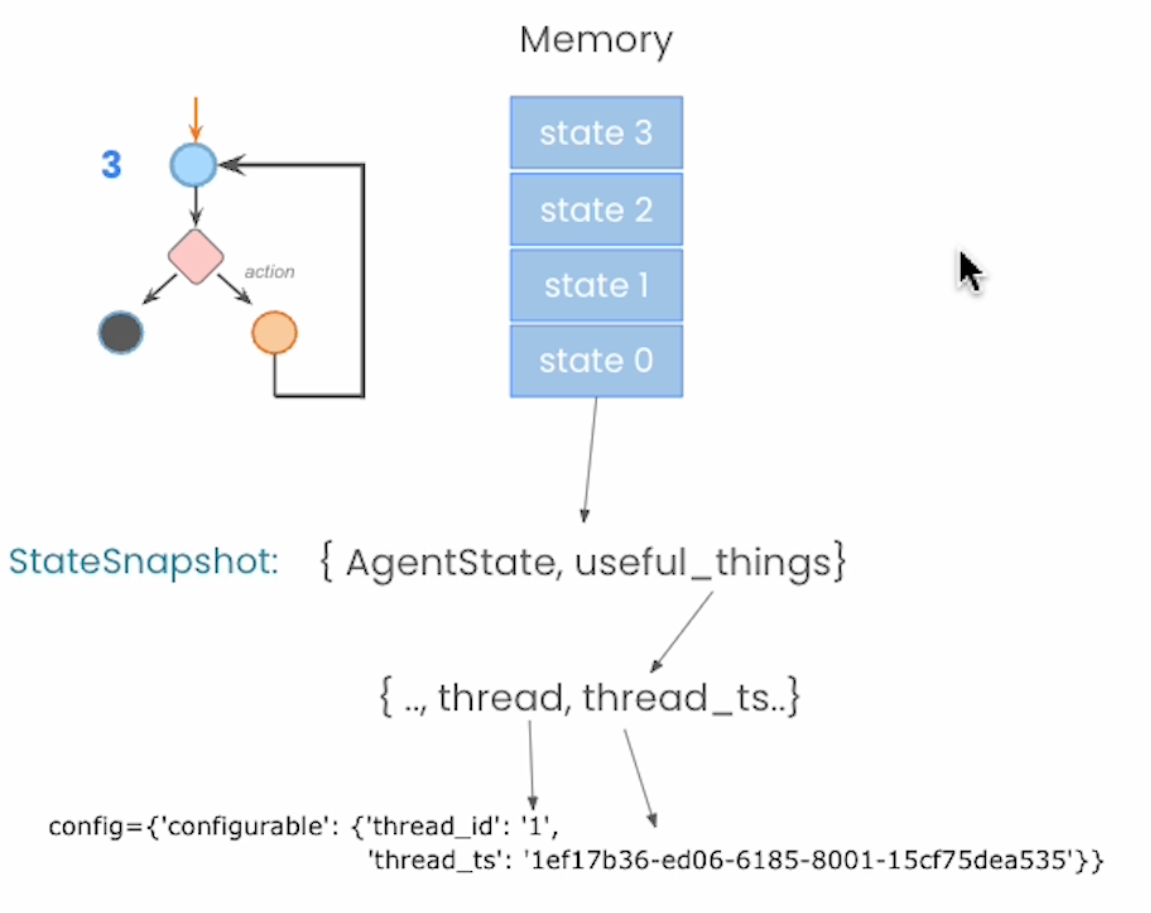

get State:

`g.get_state(thread)`

Get an iterator over all state snapshots:

`g.get_state_history(thread)`


Modify state:

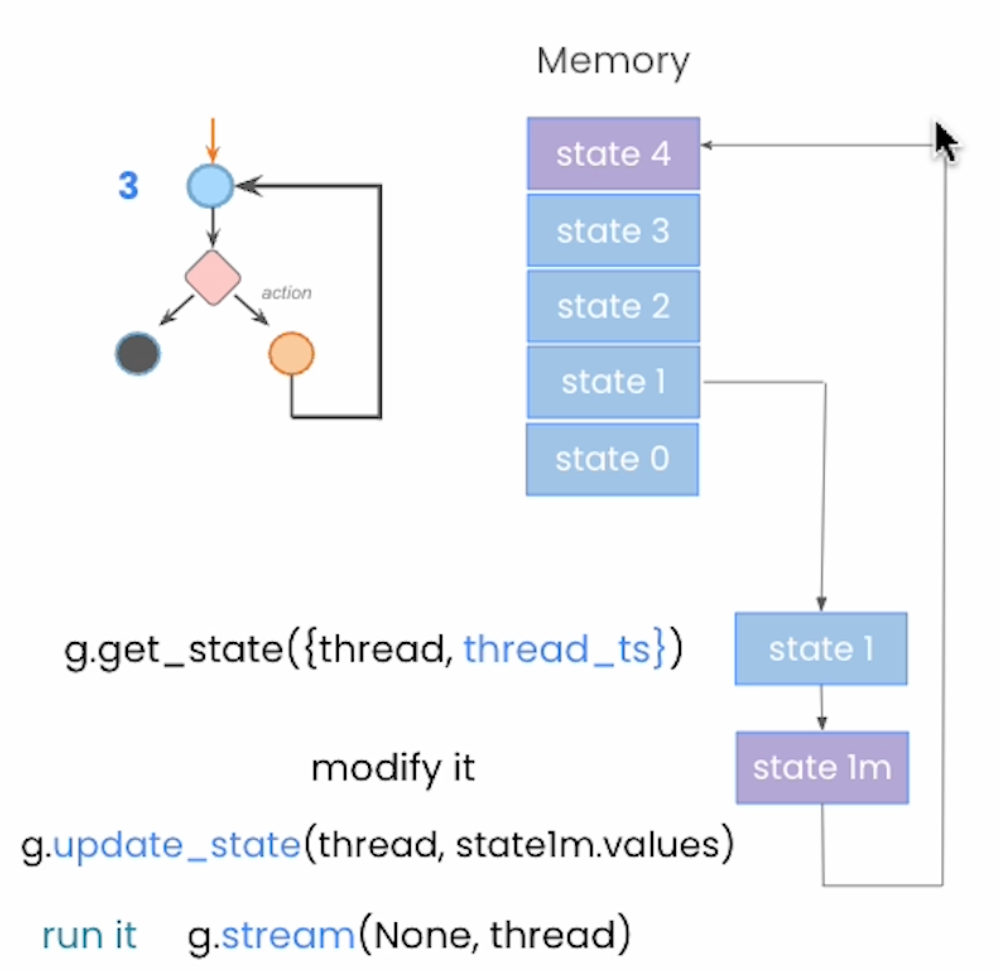


When writing using update_state(), you want to define to the graph logic which node should be assumed as the writer. What this does is allow th graph logic to find the node on the graph. After writing the values, the next() value is computed by travesing the graph using the new state. In this case, the state we have was written by Node1. The graph can then compute the next state as being Node2. Note that in some graphs, this may involve going through conditional edges

In [6]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")
from dotenv import load_dotenv

_ = load_dotenv()
_set_env("TAVILY_API_KEY")
_set_env("OPENAI_API_KEY")

In [7]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
To support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [21]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            # interrupt the model before the action node, for manual interaction
            interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [9]:
tool = TavilySearchResults(max_results=2)

In [18]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-3.5-turbo")

In [19]:
messages = [HumanMessage(content="Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "1"}}

In [20]:
messages = [HumanMessage(content="Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "1"}}
# Use the context manager for SqliteSaver
with SqliteSaver.from_conn_string(":memory:") as memory:
    # Instantiate the Agent with the checkpointer
    abot = Agent(model, [tool], system=prompt, checkpointer=memory)
    
    # Use the agent's graph
    for event in abot.graph.stream({"messages": messages}, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in SF?', id='1f52e9e7-bb24-4eb6-b293-0623b34fc7a4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fHcMb7SU8ZfWaUwIREnuZUM0', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f7443287-f4a7-49e9-8e50-1f627093fa70-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_fHcMb7SU8ZfWaUwIREnuZUM0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 22, 'total_tokens': 174})]}
{'messages': [AIMessage(co

### Modufy state

In [36]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "3"}}
with SqliteSaver.from_conn_string(":memory:") as memory:
    # Instantiate the Agent with the checkpointer
    abot = Agent(model, [tool], system=prompt, checkpointer=memory)
    for event in abot.graph.stream({"messages": messages}, thread):
        for v in event.values():
            print(v)
    current_values = abot.graph.get_state(thread)
    #print(current_values.values['messages'][-1])
    current_values.values['messages'][-1]
    _id = current_values.values['messages'][-1].tool_calls[0]['id']
    current_values.values['messages'][-1].tool_calls = [
        {'name': 'tavily_search_results_json',
    'args': {'query': 'current weather in Louisiana'},
    'id': _id}
    ]
    states = []
    _id = current_values.values['messages'][-1].tool_calls[0]['id']
    current_values.values['messages'][-1].tool_calls = [
        {'name': 'tavily_search_results_json',
    'args': {'query': 'current weather in Louisiana'},
    'id': _id}
    ]
    for state in abot.graph.get_state_history(thread):
        print(state)
        print('--')
        states.append(state)
    





{'messages': [HumanMessage(content='Whats the weather in LA?', id='40acc16d-319c-486f-a7b9-3d8b83780624'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_auviZVvTwpfOc72lS2JcvcOg', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a07d11c8-00f8-4f12-b060-4714aa3d4790-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_auviZVvTwpfOc72lS2JcvcOg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}
{'messages': [AIMessage(content='', additional

In [37]:
print(states[-3])

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='40acc16d-319c-486f-a7b9-3d8b83780624'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_auviZVvTwpfOc72lS2JcvcOg', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a07d11c8-00f8-4f12-b060-4714aa3d4790-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_auviZVvTwpfOc72lS2JcvcOg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}, next=('action',), config

### Smaller graph

View all the statesnapshots in memory. You can use the displayed count agentstate variable to help track what you see. Notice the most recent snapshots are returned by the iterator first. Also note that there is a handy step variable in the metadata that counts the number of steps in the graph execution. This is a bit detailed - but you can also notice that the parent_config is the config of the previous node. At initial startup, additional states are inserted into memory to create a parent. This is something to check when you branch or time travel below.


In [38]:
class AgentState(TypedDict):
    lnode: str
    scratch: str
    count: Annotated[int, operator.add]

def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {"lnode": "node_1",
            "count": 1,
           }
def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1,
           }

In [39]:
def should_continue(state):
    return state["count"] < 3

In [40]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

builder.add_edge("Node1", "Node2")
builder.add_conditional_edges("Node2", 
                              should_continue, 
                              {True: "Node1", False: END})
builder.set_entry_point("Node1")

In [58]:
with SqliteSaver.from_conn_string(":memory:") as memory:
    graph = builder.compile(checkpointer=memory)
    thread = {"configurable": {"thread_id": str(1)}}
    graph.invoke({"count":0, "scratch":"hi"},thread)
    graph.get_state(thread)
    states = []
    states = []
    for state in graph.get_state_history(thread):
        states.append(state.config)
        print(state.config, state.values['count'])
    graph.get_state(states[-3])
    graph.invoke(None, states[-3])
    thread2 = {"configurable": {"thread_id": str(2)}}
    graph.invoke({"count":0, "scratch":"hi"},thread2)
    states2 = []
    for state in graph.get_state_history(thread2):
        states2.append(state.config)
        print(state.config, state.values['count'])  

    save_state = graph.get_state(states2[-3])
    graph.update_state(thread2,save_state.values, as_node="Node1")
    for i, state in enumerate(graph.get_state_history(thread2)):
        if i >= 3:  #print latest 3
            break
        print(state, '\n')

node1, count:0
node2, count:1
node1, count:2
node2, count:3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef90019-72fc-6cd0-8004-0ab3692cceba'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef90019-72fa-64bc-8003-9c65fe95a4a8'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef90019-72f8-6054-8002-66b8eebdcef7'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef90019-72f5-6e58-8001-c78e623a0bad'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef90019-72f2-660e-8000-3bf3c452c698'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef90019-72ef-6eb8-bfff-e49a88439ce8'}} 0
node2, count:1
node1, count:2
node2, count:3
node1, count:0
node2, count:1
node1, count:2
node2, count:3
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1ef90019-7320-6428-8004-16847b3aa139'}} 4
{'configurable':

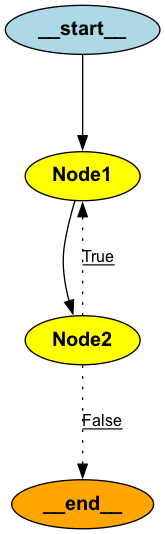

In [57]:
from IPython.display import Image

Image(graph.get_graph().draw_png())